###### Importing necessary libraries

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pmdarima import auto_arima
import pmdarima as pm

from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

import warnings       
warnings.filterwarnings("ignore")
sns.set_style('darkgrid')


from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly


In [101]:
## Read the ‘csv’ files provided

In [102]:
df=pd.read_csv(r"D:\Data(D)\Durham College\Artificial Inteligence\Sem_1\Capstone_1\Predicting the sales of products of a retail chain\train_data.csv")

In [103]:
df.head()

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales
0,2012-01-01,74,11,others,111,Maharashtra,0
1,2012-01-01,337,11,others,111,Maharashtra,1
2,2012-01-01,423,12,others,111,Maharashtra,0
3,2012-01-01,432,12,others,111,Maharashtra,0
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0


In [104]:
price=pd.read_csv(r"D:\Data(D)\Durham College\Artificial Inteligence\Sem_1\Capstone_1\Predicting the sales of products of a retail chain\product_prices.csv")

In [105]:
price

,outlet,product_identifier,week_id,sell_price
0,111,74,49,2.94
1,111,74,50,2.94
2,111,74,51,2.94
3,111,74,52,2.94
4,111,74,53,2.94
...,...,...,...,...
58995,333,3021,162,2.08
58996,333,3021,163,2.08
58997,333,3021,164,2.08
58998,333,3021,165,2.08


In [106]:
df.shape

(395000, 7)

In [107]:
date=pd.read_csv(r"D:\Data(D)\Durham College\Artificial Inteligence\Sem_1\Capstone_1\Predicting the sales of products of a retail chain\date_to_week_id_map.csv")

In [108]:
date.head()

,date,week_id
0,2012-01-01,49
1,2012-01-02,49
2,2012-01-03,49
3,2012-01-04,49
4,2012-01-05,49


In [109]:
## merging the data sets

In [110]:
x=pd.merge(price,date, on=['week_id'], how='inner')
df=pd.merge(df,x, on=['date','product_identifier','outlet'], how='inner')
df

,date,product_identifier,department_identifier,category_of_product,outlet,state,sales,week_id,sell_price
0,2012-01-01,74,11,others,111,Maharashtra,0,49,2.94
1,2012-01-01,337,11,others,111,Maharashtra,1,49,7.44
2,2012-01-01,423,12,others,111,Maharashtra,0,49,0.97
3,2012-01-01,432,12,others,111,Maharashtra,0,49,4.97
4,2012-01-01,581,21,fast_moving_consumer_goods,111,Maharashtra,0,49,4.88
...,...,...,...,...,...,...,...,...,...
394995,2014-02-28,2932,33,drinks_and_food,333,Kerala,2,161,2.78
394996,2014-02-28,2935,33,drinks_and_food,333,Kerala,8,161,0.20
394997,2014-02-28,3004,33,drinks_and_food,333,Kerala,0,161,2.50
394998,2014-02-28,3008,33,drinks_and_food,333,Kerala,0,161,1.98


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395000 entries, 0 to 394999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   date                   395000 non-null  object 
 1   product_identifier     395000 non-null  int64  
 2   department_identifier  395000 non-null  int64  
 3   category_of_product    395000 non-null  object 
 4   outlet                 395000 non-null  int64  
 5   state                  395000 non-null  object 
 6   sales                  395000 non-null  int64  
 7   week_id                395000 non-null  int64  
 8   sell_price             395000 non-null  float64
dtypes: float64(1), int64(5), object(3)
memory usage: 30.1+ MB


In [112]:
# checking the correlation between the features

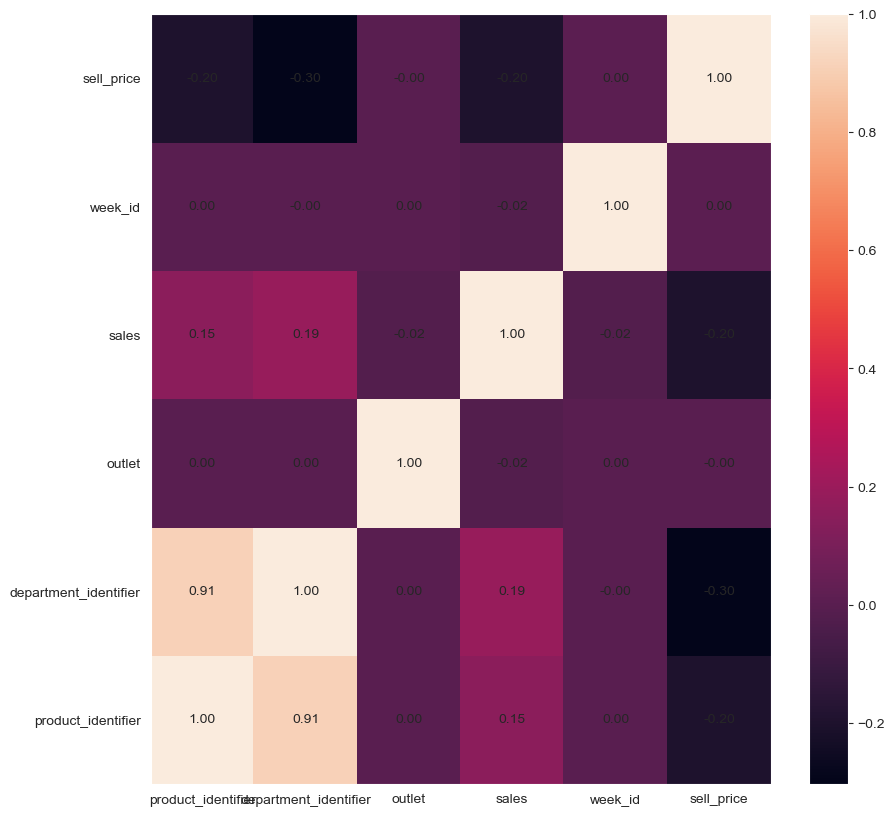

In [113]:
fig = plt.figure(figsize=(10,10))
corr = df.corr()
c = plt.pcolor(corr)
plt.yticks(np.arange(0.5, len(corr.index), 1), corr.index)
plt.xticks(np.arange(0.5, len(corr.columns), 1), corr.columns)

# Add correlation values to the cells
for i in range(len(corr.index)):
    for j in range(len(corr.columns)):
        plt.text(j+0.5, i+0.5, '{:.2f}'.format(corr.iloc[i,j]), ha='center', va='center')

fig.colorbar(c)
plt.show()


In [114]:
# Changing the datatypes to suitable types

In [115]:
df['date'] = pd.to_datetime(df['date'])
df['product_identifier'] = df['product_identifier'].astype('category')
df['department_identifier'] = df['department_identifier'].astype('category')
df['category_of_product'] = df['category_of_product'].astype('category')
df['outlet'] = df['outlet'].astype('category')
df['state'] = df['state'].astype('category')
df['sales'] = df['sales'].astype('int64')
df['week_id'] = df['week_id'].astype('category')

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395000 entries, 0 to 394999
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   395000 non-null  datetime64[ns]
 1   product_identifier     395000 non-null  category      
 2   department_identifier  395000 non-null  category      
 3   category_of_product    395000 non-null  category      
 4   outlet                 395000 non-null  category      
 5   state                  395000 non-null  category      
 6   sales                  395000 non-null  int64         
 7   week_id                395000 non-null  category      
 8   sell_price             395000 non-null  float64       
dtypes: category(6), datetime64[ns](1), float64(1), int64(1)
memory usage: 14.3 MB


In [117]:
df.describe()

,sales,sell_price
count,395000.000000,395000.000000
mean,1.228919,4.987644
std,3.595266,3.874444
min,0.000000,0.050000
25%,0.000000,2.680000
50%,0.000000,3.980000
75%,1.000000,6.480000
max,293.000000,44.360000


In [118]:
df.nunique()

date                     790
product_identifier        50
department_identifier      6
category_of_product        3
outlet                    10
state                      3
sales                    126
week_id                  113
sell_price               107
dtype: int64

In [119]:
df.corr()['sales']

sales         1.000000
sell_price   -0.198098
Name: sales, dtype: float64

In [120]:
#### other Features have no correlation with the sales feature.

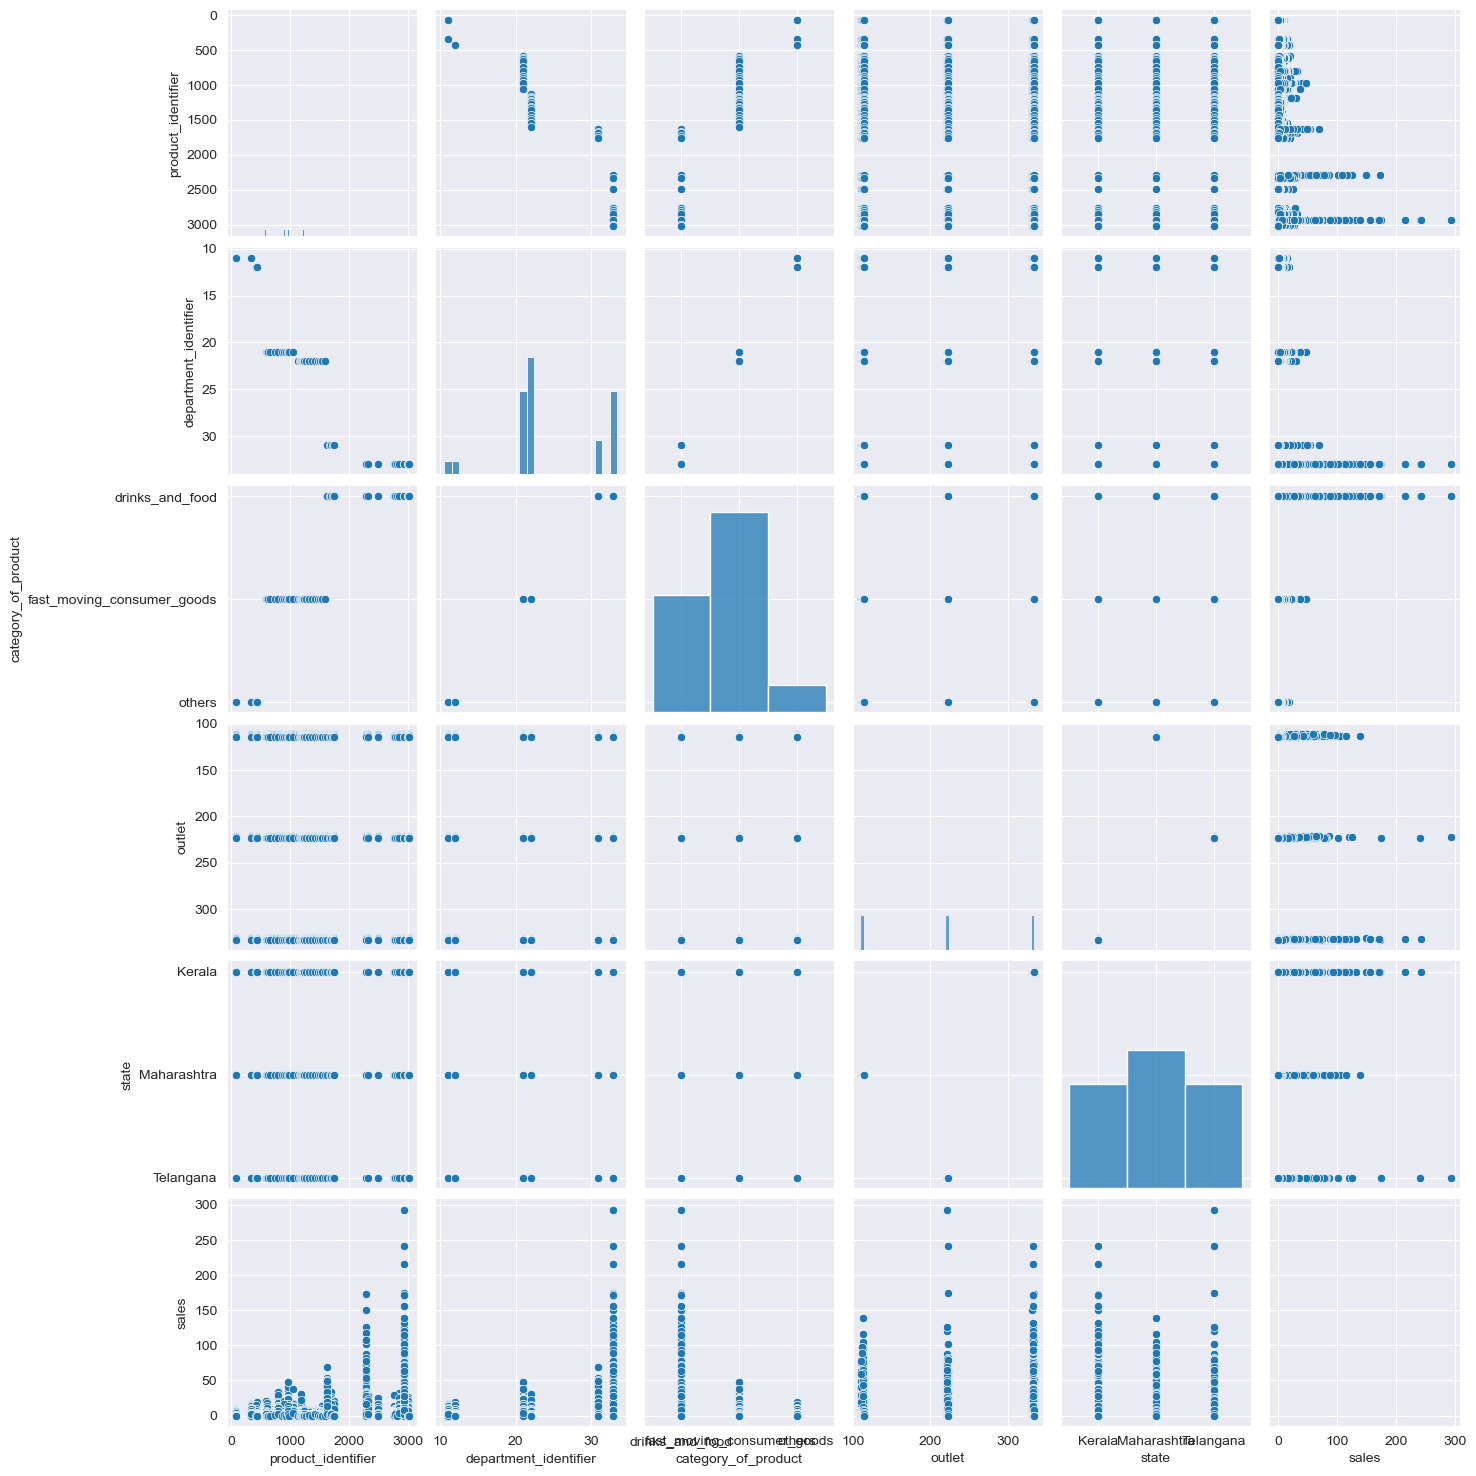

In [121]:
sns.pairplot(df, vars=['product_identifier','department_identifier','category_of_product','outlet','state','sales'])

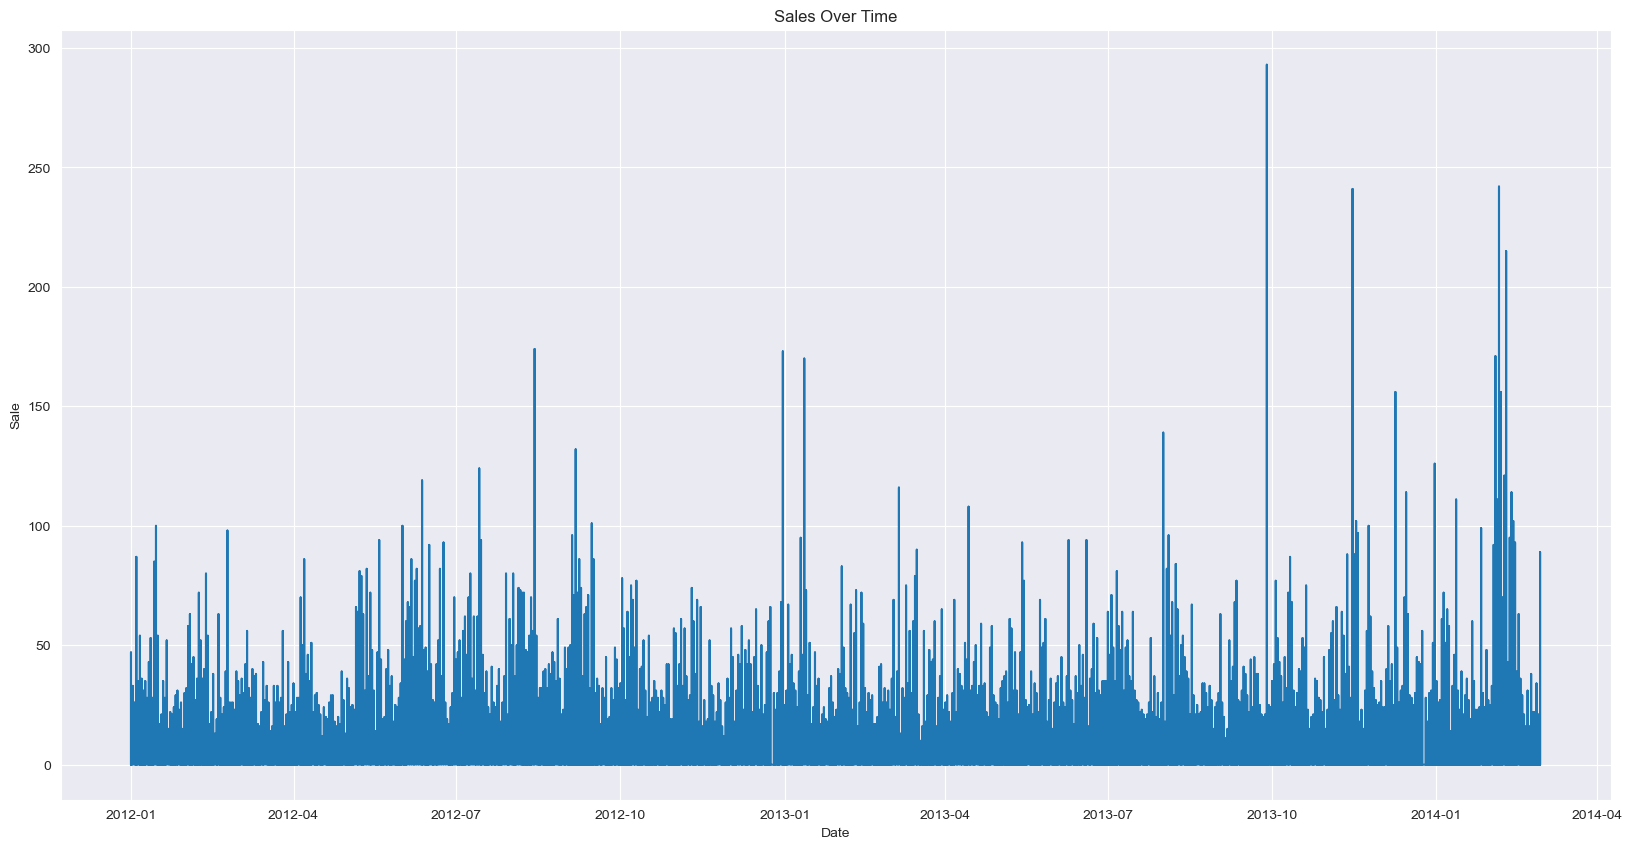

In [122]:
plt.figure(figsize=(20,10))
plt.plot(df['date'],df['sales'])
plt.xlabel('Date')
plt.ylabel('Sale')
plt.title('Sales Over Time')
plt.show()

## Indexing time series data

In [123]:
df = df.set_index(['date'])

In [124]:
df.index.min(), df.index.max()

(Timestamp('2012-01-01 00:00:00'), Timestamp('2014-02-28 00:00:00'))

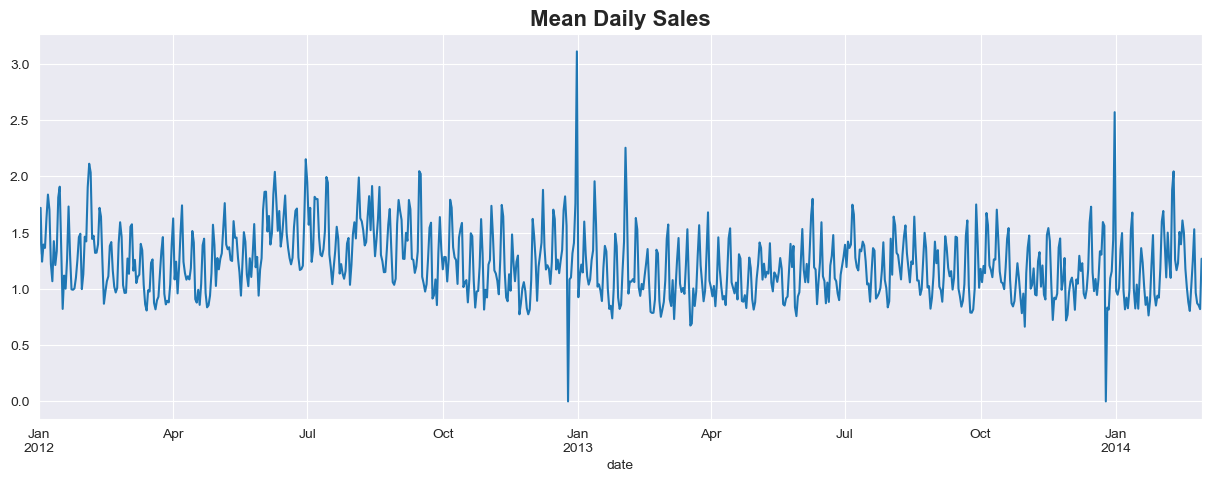

In [125]:
#observing mean daily sales of drinks_and_food
df['sales'].resample('D').mean().plot(figsize = (15,5))
plt.title('Mean Daily Sales', fontsize=16, fontweight='bold')
plt.show()

###### The drop in sales by the end of the year is due the shop closing on 25th Dec

## Resampling the data 

date
2012-01-01    1.328903
2012-02-01    1.341034
2012-03-01    1.116774
2012-04-01    1.178533
2012-05-01    1.298194
2012-06-01    1.562867
2012-07-01    1.420000
2012-08-01    1.487742
2012-09-01    1.366733
2012-10-01    1.222968
2012-11-01    1.141800
2012-12-01    1.374129
2013-01-01    1.147032
2013-02-01    1.135143
2013-03-01    1.110645
2013-04-01    1.055267
2013-05-01    1.104323
2013-06-01    1.193867
2013-07-01    1.211935
2013-08-01    1.242645
2013-09-01    1.142333
2013-10-01    1.155613
2013-11-01    1.111933
2013-12-01    1.164516
2014-01-01    1.062581
2014-02-01    1.274429
Freq: MS, Name: sales, dtype: float64


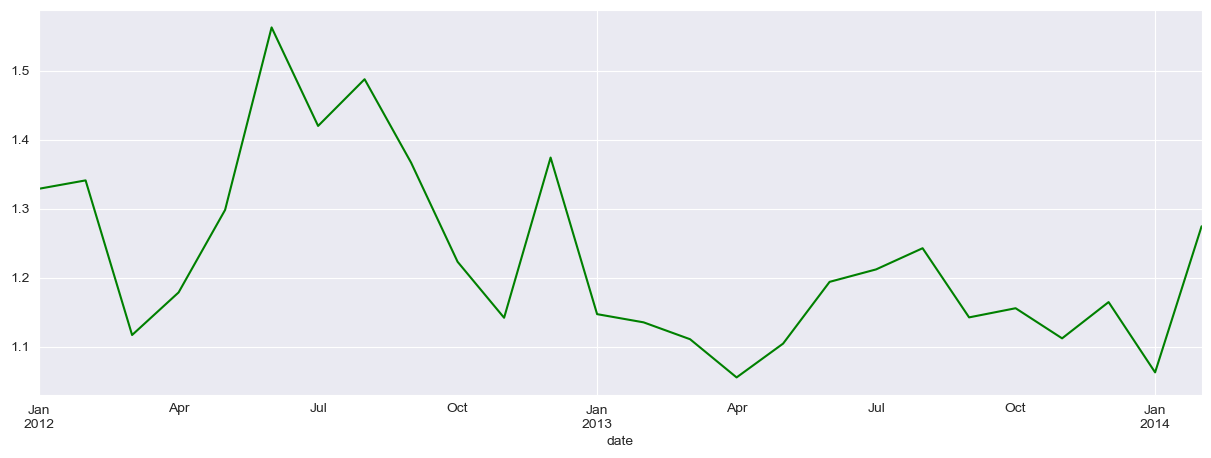

In [126]:
#monthly mean sales begin
mean_monthlysales = df.resample(rule='MS').mean()['sales']
print(mean_monthlysales)
sns.set_style('darkgrid')
mean_monthlysales.plot(figsize=(15,5),c='green')
plt.show()

## Note:
#### Mean monthly sales is maximum in month march of year 2012.
#### Also on month June 2012, Aug 2012, Dec 2012, Feb 2012 shows higher sales.
#### There is a huge dip in the graph during April 2013 which shows least sales.